# Here we will explore structure-activity relationship (SAR)

In drug discovery projects, we often have a CSV file containing SMILES strings for a handful of reported molecules and their measured bioactivity against a protein target.

It then becomes essential to address the following questions:

Can a binding hypothesis for this chemical series be proposed? Does it explain the observed SAR? Which experiments cane be suggested to confirm that hypothesis? Can you guess the relative potency of the compound with no associated bioactivity data in the file?

In this notebook, I will try to simulate such as a scenario using an SAR dataset and address the above questions

**Phase-1 of the notebook consists of following sections:**

1. [Group molecules according to their Bemis Murcko Scaffolds](#group-molecules-according-to-their-bemis-murcko-scaffolds)

2. [Relate bioactivity distribution with scaffolds](#relate-activity-distribution-with-scaffolds)

3. [Examine molecules with same scaffold](#examine-molecules-within-the-same-scaffold)

**The Phase-2 of this notebook begins from the following sections:**

4. [Create R-group table to examine substituents on a common scaffold](#create-a-r-group-table-to-examine-substituents-on-the-common-scaffold)

5. [Check frequencies of scaffolds and their substituents](#check-frequencies-of-core-scaffold-and-r-groups)

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, Draw
# This is essential when rendering a Pandas dataframe with R-group results
PandasTools.RenderImagesInAllDataFrames(images=True)
from rdkit.Chem.rdDepictor import Compute2DCoords
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D
from rdkit.Chem import rdFMCS, rdRGroupDecomposition
import useful_rdkit_utils as uru
import io
import base64
import mols2grid
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns

### Read and analyse the dataset

In [2]:
df = pd.read_csv("data/smiles_pKi.csv")
print(f"The CSV file contains {df.shape[0]} molecules and their activities")

df.head(3)

The CSV file contains 555 molecules and their activities


,ID,pKi,Smiles
0,CHEMBL3685195,8.70,O=C(Nc1ccc(Cl)c(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c...
1,CHEMBL3685132,8.15,Cn1ccc(Oc2ccc3cc(NC(=O)C4CC4)ncc3c2)n1
2,CHEMBL3685135,7.96,O=C(Nc1cc2ccc(-c3ccc4cn[nH]c4c3)cc2cn1)C1CC1


In [3]:
df.columns

Index(['ID', 'pKi', 'Smiles'], dtype='object')

In [4]:
# Check which columns have how many null values:
df.isnull().sum()

ID        0
pKi       0
Smiles    0
dtype: int64

Looks like the acitvity values of pKi IC50 mTor has less number of the nan value than pKi IC50 pi3k. Hence, for this exercise, we will use mTor activity values.

We will remove the SMILES that do not have a mTor activity measured.

In [5]:
new_df = df[df['pKi'].notna()]

# Remove the unneeded columns
#new_df = new_df[["SMILES", "pKi IC50 mTor"]]

# Rename "pKi IC50 mTor" to simply "pKi"
#new_df = new_df.rename(columns={"pKi IC50 mTor": "pKi"})

print(f"There are now {new_df.shape[0]} molecules in the dataframe from the previous {df.shape[0]}")

There are now 555 molecules in the dataframe from the previous 555


In [6]:
new_df.head(2)

,ID,pKi,Smiles
0,CHEMBL3685195,8.70,O=C(Nc1ccc(Cl)c(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c...
1,CHEMBL3685132,8.15,Cn1ccc(Oc2ccc3cc(NC(=O)C4CC4)ncc3c2)n1


<Axes: xlabel='pKi', ylabel='Count'>

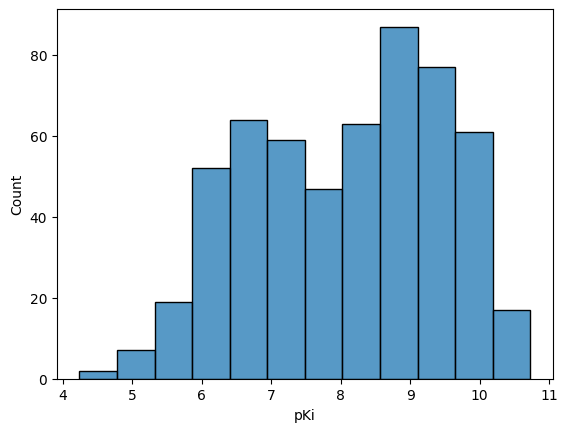

In [7]:
# Visualise the distribution of activity:
sns.histplot(new_df['pKi'])    

Looks like we have a nice (almost) uniform distribution

### Visualise the dataset

Now we calculate the mol object:

In [8]:
new_df['mol'] = new_df['Smiles'].apply(Chem.MolFromSmiles)

,ID,pKi,Smiles,mol
0,CHEMBL3685195,8.70,O=C(Nc1ccc(Cl)c(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c...,
1,CHEMBL3685132,8.15,Cn1ccc(Oc2ccc3cc(NC(=O)C4CC4)ncc3c2)n1,

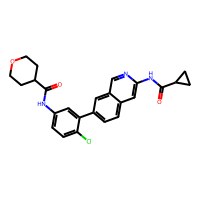
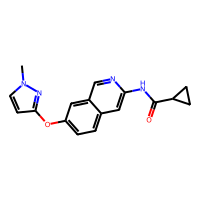

In [9]:
new_df.head(2)

In [10]:
# Visualise the SMILES
mols2grid.display(new_df.mol[:8], size=(200,200), subset=["img", "SMILES"])

MolGridWidget()

## Group molecules according to their Bemis-Murcko scaffolds 

In [11]:
# Calculate the Murcko scaffold for each molecule
new_df['scaffold_smi'] = new_df.Smiles.apply(Chem.Scaffolds.MurckoScaffold.MurckoScaffoldSmiles)

,ID,pKi,Smiles,mol,scaffold_smi
0,CHEMBL3685195,8.70,O=C(Nc1ccc(Cl)c(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c...,,O=C(Nc1cccc(-c2ccc3cc(NC(=O)C4CC4)ncc3c2)c1)C1...
1,CHEMBL3685132,8.15,Cn1ccc(Oc2ccc3cc(NC(=O)C4CC4)ncc3c2)n1,,O=C(Nc1cc2ccc(Oc3cc[nH]n3)cc2cn1)C1CC1

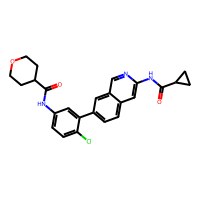
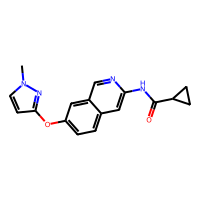

In [12]:
new_df.head(2)

In [13]:
# Create a new dataframe with the unique Bemis-Murcko scaffolds and the number of molecules with the 
# scaffold in the initial dataset.
scaffold_df = uru.value_counts_df(new_df,"scaffold_smi")

In [14]:
# Visualise the top five scaffolds and their counts
scaffold_df.head(5)

,scaffold_smi,count
0,O=C(Nc1cc2ccc(-c3ccccc3)cc2cn1)C1CC1,60
1,O=C(Nc1cc2ccc(-c3cccnc3)cc2cn1)C1CC1,52
2,c1ccc(CCn2ncc3c(NCc4ccccc4)ncnc32)cc1,44
3,c1ccc(-c2ccc3ccncc3c2)cc1,24
4,O=C(Nc1nnc(SCc2ccccc2)s1)c1ccccc1,21


,scaffold_smi,count,mol
0,O=C(Nc1cc2ccc(-c3ccccc3)cc2cn1)C1CC1,60,
1,O=C(Nc1cc2ccc(-c3cccnc3)cc2cn1)C1CC1,52,
2,c1ccc(CCn2ncc3c(NCc4ccccc4)ncnc32)cc1,44,
3,c1ccc(-c2ccc3ccncc3c2)cc1,24,
4,O=C(Nc1nnc(SCc2ccccc2)s1)c1ccccc1,21,

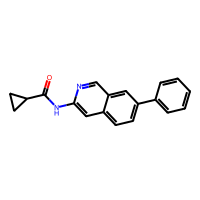
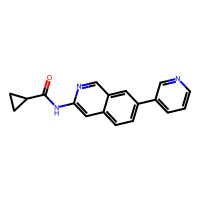
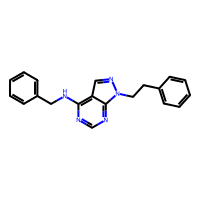
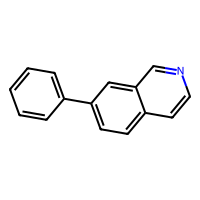
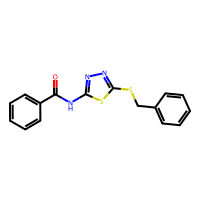

In [15]:
#create mol objects for the scaffold SMILES
scaffold_df['mol'] = scaffold_df.scaffold_smi.apply(Chem.MolFromSmiles)

scaffold_df.head()

In [16]:
# Check what the scaffolds look like side by side:
mols2grid.display(scaffold_df.mol[:8], mol_col="mol",size=(200,200), subset=["img", "SMILES"])

MolGridWidget()

We can use a simple plot to visualize the number of molecules with each scaffold.  

The plot below, the top 30 scaffolds are arrayed on the x-axis.  The y-axis shows the number of examples molecules with each scaffold.  We can see that scaffold 0 has the maximum 118 molecules, scaffold 1 has 49 examples, etc. and so on. 

Text(0, 0.5, 'Number of Examples')

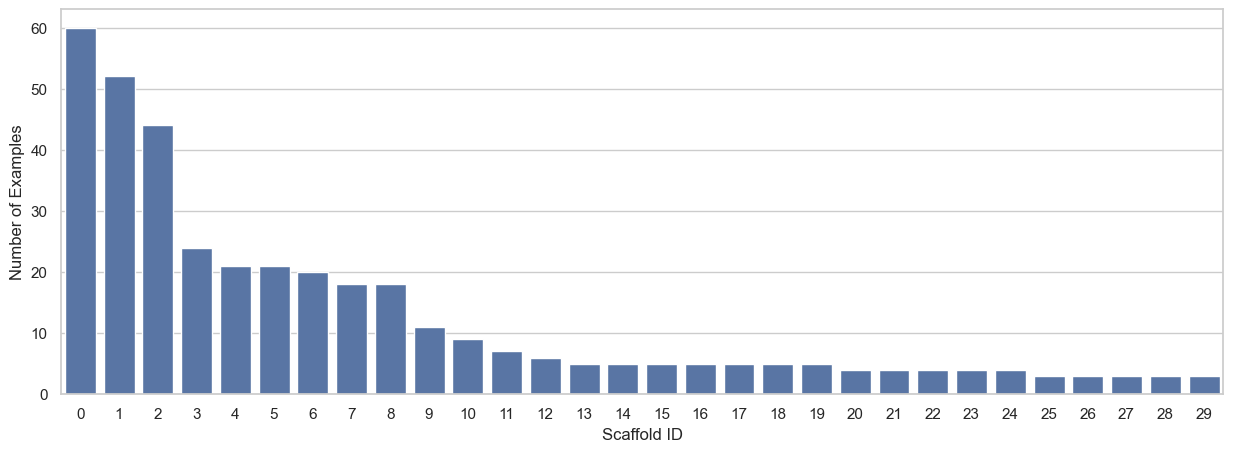

In [17]:
sns.set(rc={'figure.figsize': (15, 5)})
sns.set_style('whitegrid')
ax = sns.barplot(x=range(0,len(scaffold_df[:30])),y=scaffold_df["count"][:30].values)
ax.set_xlabel("Scaffold ID")
ax.set_ylabel("Number of Examples")

## Relate activity distribution with scaffolds

It's useful to examine the activity distributions associated with each of the scaffolds. 

To do this, we'll display a table with the scaffold, the number of molecules with that scaffold, and a box plot showing the associated activity distributions. To make life easier, we will define a couple of support functions. 

In [18]:
def boxplot_base64_image(dist: np.ndarray, x_lim: list[int] = [0, 10]) -> str:
    """
    Plot a distribution as a seaborn boxplot and save the resulting image as a base64 image.

    Parameters:
    dist (np.ndarray): The distribution data to plot.
    x_lim (list[int]): The x-axis limits for the boxplot.

    Returns:
    str: The base64 encoded image string.
    """
    sns.set(rc={'figure.figsize': (3, 1)})
    sns.set_style('whitegrid')
    ax = sns.boxplot(x=dist)
    ax.set_xlim(x_lim[0], x_lim[1])
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return '<img align="left" src="data:image/png;base64,%s">' % s


def mol_to_base64_image(mol: Chem.Mol) -> str:
    """
    Convert an RDKit molecule to a base64 encoded image string.

    Parameters:
    mol (Chem.Mol): The RDKit molecule to convert.

    Returns:
    str: The base64 encoded image string.
    """
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 150)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    text = drawer.GetDrawingText()
    im_text64 = base64.b64encode(text).decode('utf8')
    img_str = f"<img src='data:image/png;base64, {im_text64}'/>"
    return img_str

With the functions above we can define this table with a few lines of code.


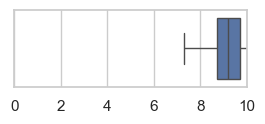
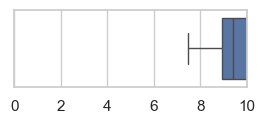
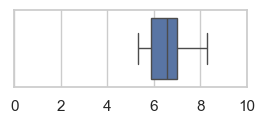
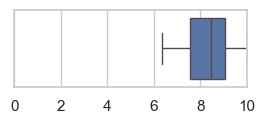
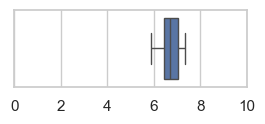
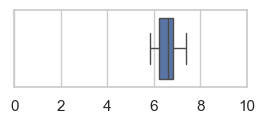
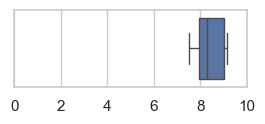
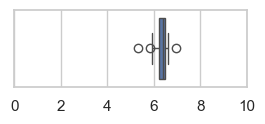
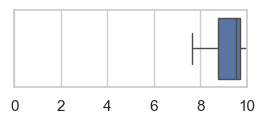
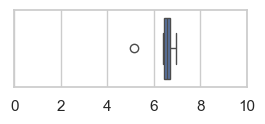

In [19]:
rows_to_display = 10
tmp_df = scaffold_df.head(rows_to_display).copy()
tmp_df['mol_img'] = tmp_df.mol.apply(mol_to_base64_image)
img_list = []
for smi in tmp_df.scaffold_smi:
    img_list.append(boxplot_base64_image(new_df.query("scaffold_smi == @smi").pKi.values))
tmp_df['dist_img'] = img_list
HTML(tmp_df[['mol_img','count','dist_img']].to_html(escape=False))

## Examine molecules within the same scaffold

After looking the figure above, we may want to perform a more detailed analysis of the molecules in each of the scaffold groups above. By changing the ```scaffold_id``` field below we can view different sets of molecules with the same scaffold. The data is sorted by ```pKi IC50 mTor```. 

To facilitate SAR analysis we've aligned the structures to the scaffolds in table above.

In [20]:
# Select scaffold 1 to examine
scaffold_id = 3
scaffold_smi = scaffold_df.scaffold_smi.values[scaffold_id]

tmp_df = new_df.query("scaffold_smi == @scaffold_smi").copy()
tmp_df['mol'] = tmp_df.Smiles.apply(Chem.MolFromSmiles)
scaffold_mol = scaffold_df.mol.values[scaffold_id]
AllChem.Compute2DCoords(scaffold_mol)
[AllChem.GenerateDepictionMatching2DStructure(m,scaffold_mol) for m in tmp_df.mol]
mols2grid.display(tmp_df.sort_values("pKi"),size=(175,175),subset=["img","pKi"], mol_col="mol",
                  use_coords=True, prerender=True)

MolGridWidget()

## Create a R-group table to examine substituents on the common scaffold

Another way to examine SAR data is to create a table of substituents attached at a different positions on a common scaffold. 

This often provides a simple way of identifying the preferred substituents at each position. To do this, we first need to find the substructure that is common to all the molecules. This is commonly referred to as the ```Maximum Common Substructure``` or MCSS. 

For a deeper view of MCSS methods and how they are used in the RDKit, please consult this excellent [tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T006_compound_maximum_common_substructures.html) from the Teach Open CADD collection. We can use the ```rdFMCS.FindMCS``` method to find the MCSS for the 102 molecules in our patent. 

For more information about R-group decompositions in the RDKit, I highly recommend [this](https://greglandrum.github.io/rdkit-blog/posts/2023-01-09-rgd-tutorial.html) blog post from Greg Landrum.

### First, find the MCS

There are 24 molecules with scaffold 3


,ID,pKi,Smiles,mol,scaffold_smi
101,CHEMBL3685065,7.48,Cc1ccc(F)cc1-c1ccc2cc(NC(=O)C(F)(F)F)ncc2c1,,c1ccc(-c2ccc3ccncc3c2)cc1
115,CHEMBL3685042,8.52,Cc1ccc(F)cc1-c1ccc2cc(NC(=O)CC(F)(F)F)ncc2c1,,c1ccc(-c2ccc3ccncc3c2)cc1

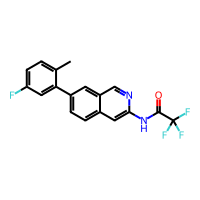
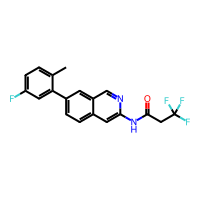

In [21]:
#get all 60 molecules having scaffold 1
scaffold_3 = new_df[new_df['scaffold_smi'] == "c1ccc(-c2ccc3ccncc3c2)cc1"]
print(f"There are {scaffold_3.shape[0]} molecules with scaffold 3")
scaffold_3.head(2)

In [22]:
mcs_res = rdFMCS.FindMCS(scaffold_3.mol.values)

The MCS is returned as SMARTS

In [23]:
mcs_res.smartsString

'[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#6]:[#7]:[#6](:[#6]:2)-[#7]'

we can convert the SMARTS to an RDKit molecule, which we can visualize. Note that this molecule is close, but not exactly what we want

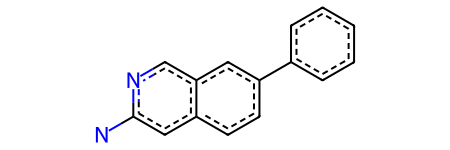

In [24]:
mcs_mol = Chem.MolFromSmarts(mcs_res.smartsString)
mcs_mol

By editing the molecule with [ketcher](https://lifescience.opensource.epam.com/KetcherDemo/index.html?api_path=/v2), we have the following core:

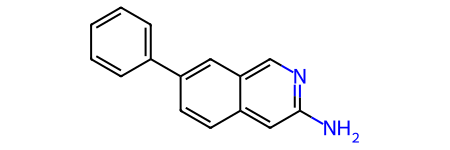

In [25]:
core_smi = "C1C(C2=CC3C=NC(N)=CC=3C=C2)=CC=CC=1"
core_mol = Chem.MolFromSmiles(core_smi)
core_mol

Now that we have our core molecule, we can use the RDKit to perform an R-group decomposition.

In [26]:
mols = scaffold_3.mol.values
rgd,fails = rdRGroupDecomposition.RGroupDecompose([core_mol],mols,asRows=True)

The ```rdRGroupDecomposition.RGroupDecompose``` method returns two values. The first is a dictionary of cores and R-groups for the decomposed molecules. We'll get to this in a minute. 

First let's look at the variable ```fails```, which contains the molecules that failed the R-group decompositon. We can see below that fails contains an empty list, indicating that the R-group decomposition succeeded for all the molecules.

In [27]:
fails

[]

We called ```rdRGroupDecomposition.RGroupDecompose``` with ```asRows=True```, so the variable ```rgd``` contains a list of dictionaries containing the core and R-groups for each molecule. Let's look at the first entry in the list ```rgd```. We can see that the dictionary contains a core and 3 R-groups as RDKit molecules.

In [28]:
# Check the dictionary at 0th index
rgd[0]

{'Core': <rdkit.Chem.rdchem.Mol at 0x2a8c6be60>,
 'R1': <rdkit.Chem.rdchem.Mol at 0x2a8c6b760>,
 'R2': <rdkit.Chem.rdchem.Mol at 0x2a9cc02e0>,
 'R3': <rdkit.Chem.rdchem.Mol at 0x2a9cc0350>,
 'R4': <rdkit.Chem.rdchem.Mol at 0x2a9cc03c0>,
 'R5': <rdkit.Chem.rdchem.Mol at 0x2a9cc0430>}

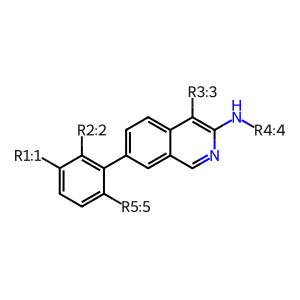

In [29]:
# Check the core scaffold of the 0th molecule
Draw.MolToImage(rgd[0]['Core'])

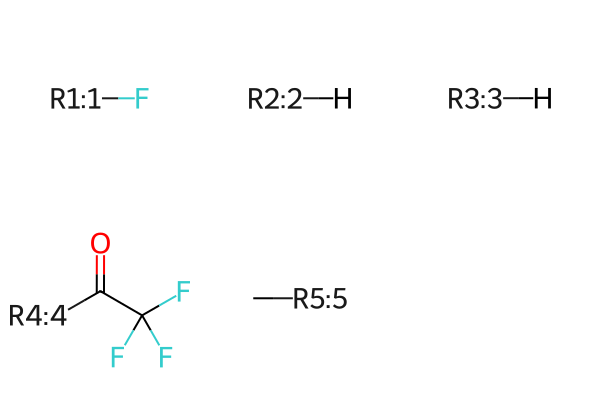

In [30]:
#Check the substituents. First create a list:
rgd0 = [rgd[0]['R1'], rgd[0]['R2'], rgd[0]['R3'], rgd[0]['R4'], rgd[0]['R5']]

Draw.MolsToGridImage(rgd0)

## Check frequencies of Core Scaffolds and R-groups 

R-group decomposition transformed the molecules, into a list of dictionaries containing the R-groups as RDKit molecules. As a next step, we would like to find the most frequently used substituents at R1, R2, R3 and R4. To do this, we first need to transform the substitutent molecules into SMILES. 

The following code loops over the rows in ```rgd``` and transforms each substituent molecule into SMILES. We can then take the list we compiled and turn it into a Pandas dataframe.

In [31]:
#Put the keys from dictionary in cols
cols = sorted(rgd[0].keys())
print(cols)

rgsmi_list = []
for row in rgd:
    rgsmi_list.append([Chem.MolToSmiles(row[x]) for x in cols])
    
rgsmi_df = pd.DataFrame(rgsmi_list,columns=cols)

['Core', 'R1', 'R2', 'R3', 'R4', 'R5']


Each molecule has been split in to its Core scaffold and substituents- R1,R2, R3 and R4

In [32]:
print(rgsmi_df.shape)
rgsmi_df.head(3)

(24, 6)


,Core,R1,R2,R3,R4,R5
0,c1cc2c([*:3])c(N[*:4])ncc2cc1-c1c([*:5])ccc([*...,F[*:1],[H][*:2],[H][*:3],O=C(C(F)(F)F)[*:4],C[*:5]
1,c1cc2c([*:3])c(N[*:4])ncc2cc1-c1c([*:5])ccc([*...,F[*:1],[H][*:2],[H][*:3],O=C(CC(F)(F)F)[*:4],C[*:5]
2,c1cc2c([*:3])c(N[*:4])ncc2cc1-c1c([*:5])ccc([*...,F[*:1],[H][*:2],[H][*:3],CC(C)NC(=O)[*:4],C[*:5]


Now that we have the data in a data frame we can use the Pandas [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) function to list the frequencies for each distinct substituent.  

The function **value_counts_df** from the [useful_rdkit_utils](https://useful-rdkit-utils.readthedocs.io/en/latest/) package is just a simple wrapper that transforms the results of **value_counts** into a dataframe. 

In [33]:
core_count_df = uru.value_counts_df(rgsmi_df,"Core") 
core_count_df

,Core,count
0,c1cc2c([*:3])c(N[*:4])ncc2cc1-c1c([*:5])ccc([*...,24


To simplify the work below, we'll wrap the two steps above into a function. We can then use the output of this function to look at which R-groups are used most frequently.

In [34]:
def tablulate_rgroups(df_in,rgroup_name, max_rows=10):
    count_df = uru.value_counts_df(df_in,rgroup_name)
    return mols2grid.display(count_df.head(max_rows),smiles_col=rgroup_name,template="static",prerender=True,size=(125,125),
                 subset=["img","count"])

### Tabulate the R1 groups

In [35]:
tablulate_rgroups(rgsmi_df,"R1")

MolGridWidget()

In [36]:
# Count the number of unique R1 groups. Even though more R1 groups are present, they are not "complete".
# Hence the above figure shows only 1 R1 group.
R1_count_df = uru.value_counts_df(rgsmi_df,"R1") 
R1_count_df

,R1,count
0,F[*:1],23
1,CCCS(=O)(=O)N[*:1],1


### Tabulate R2:

In [37]:
tablulate_rgroups(rgsmi_df,"R2")

[14:14:18] WARNING: not removing hydrogen atom with dummy atom neighbors


MolGridWidget()

In [38]:
# Count the number of unique R2 groups
R2_count_df = uru.value_counts_df(rgsmi_df,"R2") 
R2_count_df

,R2,count
0,[H][*:2],23
1,F[*:2],1


### Tabulate R3:

In [39]:
tablulate_rgroups(rgsmi_df,"R3")

[14:14:18] WARNING: not removing hydrogen atom with dummy atom neighbors


MolGridWidget()

In [40]:
# Count the number of unique R3 groups. There are only 2 unique R3 groups.
R3_count_df = uru.value_counts_df(rgsmi_df,"R3") 
R3_count_df

,R3,count
0,[H][*:3],21
1,Cl[*:3],2
2,F[*:3],1


### Tabulate R4

In [41]:
tablulate_rgroups(rgsmi_df,"R4")

[14:14:18] WARNING: not removing hydrogen atom with dummy atom neighbors


MolGridWidget()

In [42]:
# Count the number of unique R4 groups
R4_count_df = uru.value_counts_df(rgsmi_df,"R4") 
R4_count_df

,R4,count
0,CCNC(=O)[*:4],3
1,CC(=O)[*:4],2
2,[H][*:4],2
3,O=C(C(F)(F)F)[*:4],1
4,CS(=O)(=O)[*:4],1
5,COCCNC(=O)[*:4],1
6,CCC(=O)[*:4],1
7,CC(C)OC(=O)[*:4],1
8,C[*:4],1
9,COCC(=O)[*:4],1
